The label consists of infected and unifected cell images.
Each image is different so it needs to be resized.

In [1]:

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import models, layers
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras import backend as K
from tensorflow.keras.models import Model, load_model
import tensorflow as tf

#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

import os #to look in directory
import cv2
from PIL import Image #to resize images b/c they're all different sizes
import numpy as np

In [2]:
"""
image.resize((SIZE, SIZE))-convery numpy array to image and resize, then convert back to numpy
import images
resize images
What are we trying to achieve?
    trying to segment a bunch of infected and unifected cells
    train an algorithm so in hte future we can look at new images and algorithm w/confidence can predict if this is an infected or uniefected cell 

Design network:
Convolutional side
    convultional layer
    pooling layer
    Can add normalization
    dropouts
Dense layers-hidden layer
need to flatten 2D into 1D-so data can propogate into dense layer

dropouts-they minimize overfitting

------
Define the dense layers
-----
output
    activation sigmoid
"""
image_directory = '../Deep_Learning_ex/Data/cell_images/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.


parasitized_images = os.listdir(image_directory + 'Parasitized/') #in a subdirectory called 'Parasitized/'
#need to iterate through every file in subdirectory
for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object
    #go through this folder and see if it's a png image
    if (image_name.split('.')[1] == 'png'):#is this a png image, if yes,then read the image
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')#convert to PIL format
        image = image.resize((SIZE, SIZE))#resize image
        dataset.append(np.array(image))#convert back to numpy array and add to dataset
        label.append(1)
        
uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)
        
dataset = np.array(dataset)
label = np.array(label)
print("Dataset size is ", dataset.shape)
print("Label size is ", label.shape)


Dataset size is  (27558, 64, 64, 3)
Label size is  (27558,)


In [3]:
# class_names = dataset.class_names
# class_names

In [4]:
len(dataset)

27558

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256


dataset1 = tf.keras.preprocessing.image_dataset_from_directory(
    "../Deep_Learning_ex/Data/cell_images/", #this is the data directory
    seed=123,
    shuffle=True,#it will randomly shuffle images and load them 
    image_size=(IMAGE_SIZE,IMAGE_SIZE),#all images are 256 x 256
    batch_size=BATCH_SIZE #32 is standard batch size
)

Found 27558 files belonging to 2 classes.


In [6]:
class_names = dataset1.class_names
class_names

['Parasitized', 'Uninfected']

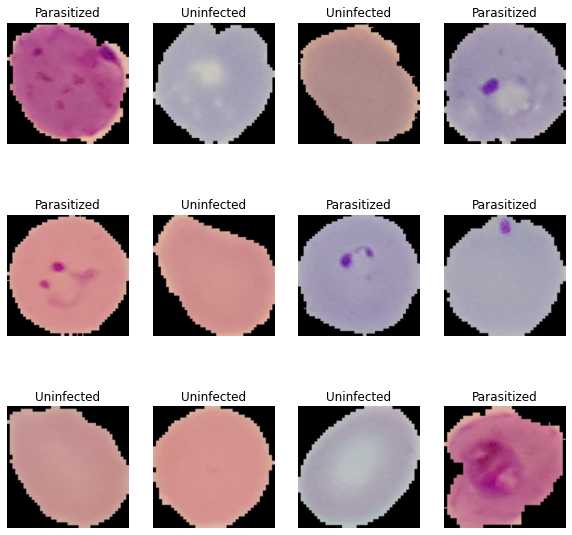

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset1.take(1):
    for i in range(12): #display 12 of the batch of 32
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('Off')

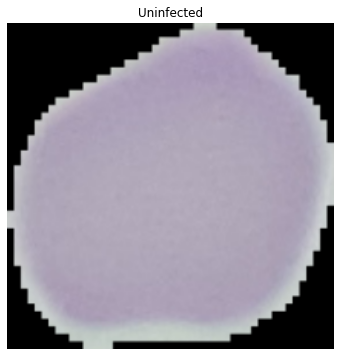

In [8]:
plt.figure(figsize=(6,6))
for image_batch, label_batch in dataset1.take(1):
    #for i in range(12): #display 12 of the batch of 32
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
        #print(image_batch[0].shape)
    plt.axis('Off')

### Split Data into Train/Test Split

In [9]:
#to_categorical(np.array(label))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)
print("Train size is ", X_train.shape)
print("Test size is ", X_test.shape)

#from keras.utils import normalize
X_train = X_train / 255
X_test = X_test / 255

Train size is  (22046, 64, 64, 3)
Test size is  (5512, 64, 64, 3)


In [10]:
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator


In [11]:
sample_generator = ImageDataGenerator(
    rescale = 1./255,
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=90,
    height_shift_range=0.2,
    width_shift_range=0.2,
    #fill_mode='constant' #there's black pixels
    zoom_range=.30
    #shear_range = 200

        )

In [12]:

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3). Images input into network


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))#puts a 2 x 2 matrix on top of previous image. In matrix pulling maximum #.
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.2))#droput 20% of data radomnly, way of regularizing algorithm to avoid overfittin or minimize it.

model.add(Conv2D(32, (3, 3))) #, kernel_initializer = 'he_uniform'
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(64, (3, 3))) #, kernel_initializer = 'he_uniform'
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.2))

#flatten layer
model.add(Flatten())
#hidden layer
model.add(Dense(256, activation='relu'))
#model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
#output layer
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('sigmoid'))  

# model = Sequential([
#     #resize_and_rescale,
#     #sample_generator,
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=INPUT_SHAPE),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     # layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     # layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     #Flatten layer
#     layers.Flatten(),
#     #Dense layer
#     layers.Dense(64, activation='relu'),
#     layers.Dense(2, activation='sigmoid'),
# ])




#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#param # 896
#loss function we're trying to minimize after every epoch
model.compile(loss='binary_crossentropy',#categorical_crossentropy
              optimizer='adam',            #also try rmsprop'
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9

In [13]:
#np.array(X_train)
history = model.fit(X_train, 
                         y_train, 
                         batch_size = 64, #takes 64 images at a time
                         verbose = 1, 
                         epochs = 20,      
                         validation_split= 0.1,
                         shuffle = False
                     )


Epoch 1/20
311/311 [==============================] - 6s 18ms/step - loss: 0.4129 - accuracy: 0.8298 - val_loss: 2.7618 - val_accuracy: 0.5052
Epoch 2/20
311/311 [==============================] - 5s 17ms/step - loss: 0.1593 - accuracy: 0.9425 - val_loss: 0.5217 - val_accuracy: 0.8422
Epoch 3/20
311/311 [==============================] - 5s 17ms/step - loss: 0.1022 - accuracy: 0.9647 - val_loss: 0.2542 - val_accuracy: 0.9256
Epoch 4/20
311/311 [==============================] - 5s 17ms/step - loss: 0.0637 - accuracy: 0.9791 - val_loss: 0.3301 - val_accuracy: 0.9202
Epoch 5/20
311/311 [==============================] - 5s 17ms/step - loss: 0.0436 - accuracy: 0.9853 - val_loss: 0.3257 - val_accuracy: 0.9147
Epoch 6/20
311/311 [==============================] - 5s 17ms/step - loss: 0.0387 - accuracy: 0.9862 - val_loss: 0.4192 - val_accuracy: 0.8916
Epoch 7/20
311/311 [==============================] - 5s 17ms/step - loss: 0.0311 - accuracy: 0.9898 - val_loss: 0.3664 - val_accuracy: 0.9138

In [14]:
print("Test accuracy: {}%".format(model.evaluate(X_test, y_test)))
#model.evaluate(X_test, y_test)

173/173 [==============================] - 1s 5ms/step - loss: 0.3456 - accuracy: 0.9503
Test accuracy: [0.3455648124217987, 0.9502902626991272]%


In [15]:
model.save('saved_models/malaria_model_100epochs.h5')

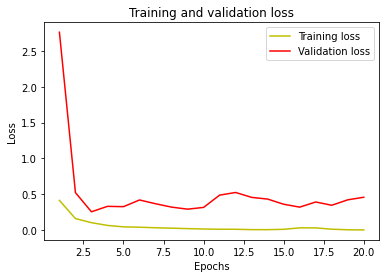

In [16]:
#is validation loss converging with train?
#voerfitting is when model is great on train set but not on test set
#if converging it tells us that the model generalized well on unseen data. Means it's ready to be deployed
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

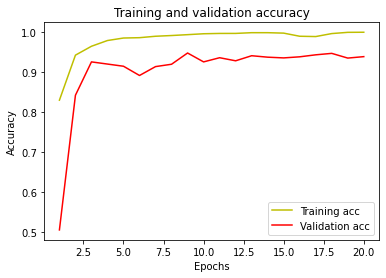

In [17]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The prediction for this image is:  [[1.]]
The actual label for this image is:  1


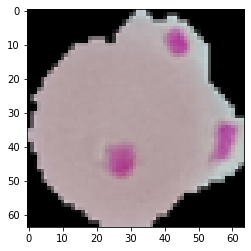

In [18]:
n=23  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])


In [19]:
#We can load the trained model, so we don't have to train again for 300 epochs!
from keras.models import load_model
# load model
model = load_model('saved_models/malaria_model_100epochs.h5')

#For 300 epochs, giving 82.5% accuracy

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")



173/173 [==============================] - 1s 5ms/step - loss: 0.3456 - accuracy: 0.9503
Accuracy =  95.02902626991272 %


In [20]:

mythreshold=0.885
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test)>= mythreshold).astype(int)
cm=confusion_matrix(y_test, y_pred)  
print(cm)

[[2766   43]
 [ 266 2437]]


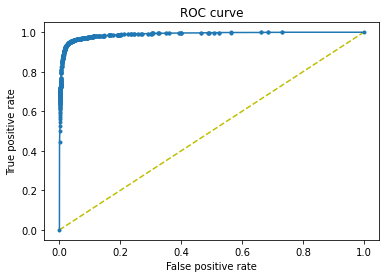

In [21]:
#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [22]:

import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 


from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)


Ideal threshold is:  265    0.002481
Name: thresholds, dtype: float32
Area under curve, AUC =  0.9893401935826219


In [23]:
import tensorflow as tf
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Deep_Learning_ex/Data/cell_images/", #this is the data directory
    seed=123,
    shuffle=True,#it will randomly shuffle images and load them 
    image_size=(IMAGE_SIZE,IMAGE_SIZE),#all images are 256 x 256
    batch_size=BATCH_SIZE #32 is standard batch size
)

Found 27558 files belonging to 2 classes.
